<a href="https://colab.research.google.com/github/Avinash-Benki/Capstone-Project/blob/master/Speech_Recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speech Recognition Using Tensorflow 



---
**Setting up Kaggle on Google Colab and Fetching Dataset**


In [0]:
!pip install kaggle

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
!mkdir .kaggle

mkdir: cannot create directory ‘.kaggle’: File exists


In [0]:
import json
token = {"username":"nivedithahn","key":"b0918f0e714fa25a112ffdbab3d43b49"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [0]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets list

In [0]:
!kaggle datasets list -s tensorflow-speech-recognition-challenge

ref                                                         title                                               size  lastUpdated          downloadCount  
----------------------------------------------------------  --------------------------------------------------  ----  -------------------  -------------  
jbuchner/synthetic-speech-commands-dataset                  Synthetic Speech Commands Dataset                    2GB  2018-06-12 06:21:36            525  
holzner/tensorflow-speech-recognition-vae-latent-variables  Tensorflow Speech recognition VAE latent variables  36MB  2018-01-12 22:09:44             63  


In [2]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/kaggle/speech'

Mounted at /content/gdrive


In [0]:
!kaggle competitions download -c tensorflow-speech-recognition-challenge -p /content/gdrive/My\ Dr
ive/kaggle/speech

  0% 0.00/501k [00:00<?, ?B/s]
100% 501k/501k [00:00<00:00, 35.2MB/s]
100% 1.04G/1.04G [00:10<00:00, 91.1MB/s]
100% 1.04G/1.04G [00:10<00:00, 108MB/s] 
100% 2.46G/2.46G [01:15<00:00, 47.8MB/s]

100% 50.0/50.0 [00:01<00:00, 32.5B/s]



In [0]:
import os
os.chdir('/content/gdrive/My Drive/kaggle/speech')

In [0]:
!ls

link_to_gcp_credits_form.txt  test     train
sample_submission.csv	      test.7z  train.7z


In [0]:
!mkdir train  #create a directory named train/
!mkdir test  #create a directory named test/

In [0]:
!ls

link_to_gcp_credits_form.txt  test     train
sample_submission.7z	      test.7z  train.7z


In [0]:
!apt-get install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [0]:
!p7zip -d train.7z

In [0]:
!p7zip -d test.7z

In [0]:
import os
os.chdir('/content/gdrive/My Drive/kaggle/speech')

In [0]:
!p7zip -d sample_submission.7z


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 512684 bytes (501 KiB)

Extracting archive: sample_submission.7z
--
Path = sample_submission.7z
Type = 7z
Physical Size = 512684
Headers Size = 146
Method = LZMA2:6m
Solid = -
Blocks = 1

  0%    Everything is Ok

Size:       4280538
Compressed: 512684


# Begining of the Speech Recognition Part

In [0]:
import os
import numpy as np
import glob
import math

In [9]:
dir_path = '/content/gdrive/My Drive/kaggle/speech'

#Getting the list of testing file names

testing_path_dir = os.path.join(dir_path,'train')
testing_path = os.path.join(testing_path_dir, 'testing_list.txt')
testing_list = np.genfromtxt(testing_path, dtype=None, encoding=None)
print("Retrieved testing_list from "+ testing_path+ ". Size is " + str(testing_list.shape)+".")

#Getting the list of Validation file names

validation_path_dir = os.path.join(dir_path,'train')
validation_path =  os.path.join(testing_path_dir, 'validation_list.txt')
validation_list = np.genfromtxt(validation_path, dtype=None, encoding=None)
print("Retrieved validation list from "+ validation_path + ". Size is " + str(validation_list.shape)+".")

#Generate training file name list 

training_path_dir = os.path.join(dir_path,'train/audio')
all_files_list = np.array(glob.glob(os.path.join(training_path_dir, '*', '*.wav')))
np.savetxt('train/all_files_list.txt',all_files_list, encoding=None, fmt='%.100s')
audio_path_length = len(training_path_dir)+1

#Training list creation by removing file names common to testing or validation list
training_list = np.array([])
for index, value in np.ndenumerate(all_files_list):
    value = value[audio_path_length:]
    all_files_list[index] = value
    if np.isin([value],testing_list)==False and np.isin([value],validation_list)==False:
        training_list = np.append(training_list, all_files_list[index])
print(str(training_list.shape) + " is the shape of the training_list.")
np.savetxt('train/training_list.txt',training_list, encoding=None, fmt='%.100s')

Retrieved testing_list from /content/gdrive/My Drive/kaggle/speech/train/testing_list.txt. Size is (6835,).
Retrieved validation list from /content/gdrive/My Drive/kaggle/speech/train/validation_list.txt. Size is (6798,).
(35328,) is the shape of the training_list.


## Data Visualization

In [0]:
# Math
from scipy.io import wavfile
import librosa
from scipy import signal

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

%matplotlib inline

In [0]:
 train_audio_path = '/content/gdrive/My Drive/kaggle/speech/train/audio/'+filename
 y, sr  = librosa.load(train_audio_path,sr=16000)

Calculating the mel-spectrum for the sample

In [7]:
# From this tutorial
# https://github.com/librosa/librosa/blob/master/examples/LibROSA%20demo.ipynb
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128, n_fft=512, hop_length=200)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)
print(mfcc.shape)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

NameError: ignored

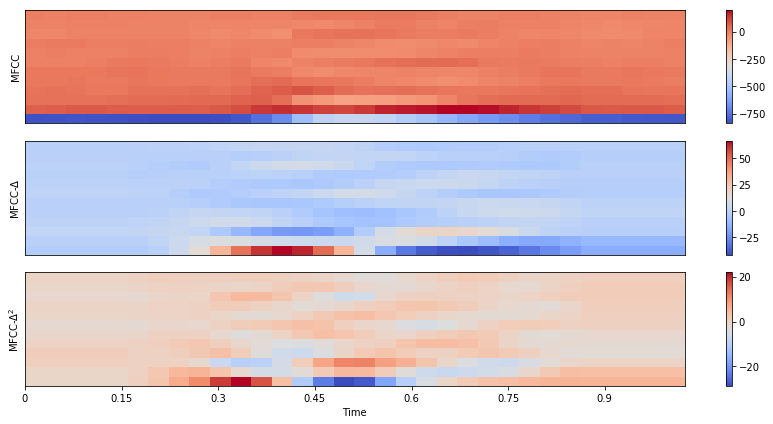

In [0]:
# Next, we'll extract the top 13 Mel-frequency cepstral coefficients (MFCCs)
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=12)

# Let's pad on the first and second deltas while we're at it
delta_mfcc  = librosa.feature.delta(mfcc)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

# How do they look?  We'll show each in its own subplot
plt.figure(figsize=(12, 6))

plt.subplot(3,1,1)
librosa.display.specshow(mfcc)
plt.ylabel('MFCC')
plt.colorbar()

plt.subplot(3,1,2)
librosa.display.specshow(delta_mfcc)
plt.ylabel('MFCC-$\Delta$')
plt.colorbar()

plt.subplot(3,1,3)
librosa.display.specshow(delta2_mfcc, sr=sr, x_axis='time')
plt.ylabel('MFCC-$\Delta^2$')
plt.colorbar()

plt.tight_layout()

# For future use, we'll stack these together into one matrix
M = np.vstack([mfcc, delta_mfcc, delta2_mfcc])

Following is the function that will calculate the mfcc coefficients 

In [0]:
def mfcc_conversion(filename, sample_rate = 16000):
  train_audio_path = '/content/gdrive/My Drive/kaggle/speech/train/audio/'+filename
  y, sr  = librosa.load(train_audio_path,sr=16000)
  
  S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128, n_fft=512, hop_length=400)

  # Convert to log scale (dB). We'll use the peak power (max) as reference.
  log_S = librosa.power_to_db(S, ref=np.max)

  mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)
  print(S.shape)
  return mfcc

In [0]:
from scipy.io import wavfile
from scipy.fftpack import dct

In [0]:
!mkdir data

In [0]:
import os
os.chdir('/content/gdrive/My Drive/kaggle/speech/data')

In [0]:
x_validation = np.empty((0,128, 81), float)


# decode validation_list
for i in range(0, validation_list.shape[0]):
    mfccs = mfcc_conversion(validation_list[i])
    mfccs = np.expand_dims(mfccs, axis=0)
    x_validation = np.vstack((x_validation, mfccs))
np.save('/content/gdrive/My Drive/kaggle/speech/data/x_validation', x_validation)    
print("Validation list audio decode complete.")

x_testing = np.empty((0,128,81), float)
# decode testing_list
for i in range(0, testing_list.shape[0]):
    mfccs = mfcc_conversion(testing_list[i])
    mfccs = np.expand_dims(mfccs, axis=0)
    x_testing = np.vstack((x_testing, mfccs))
np.save('/content/gdrive/My Drive/kaggle/speech/data/x_testing', x_testing)
print("Testing list audio decode complete.")


In [0]:
print(x_training.shape)
print(x_training[1][1][1])

(35328, 128, 41)
5.173680977183568e-05


In [8]:
from tensorflow import keras
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
# audio targets are determined by the name of their parent folder
def audio_categorizer(x_arr):
    y_arr=np.array([])
    for index, value in np.ndenumerate(x_arr):
        keyword = os.path.dirname(value)
        if keyword == "yes":
            y_arr = np.append(y_arr,1)
        elif keyword == "no":
            y_arr = np.append(y_arr,2)
        elif keyword == "up":
            y_arr = np.append(y_arr,3)
        elif keyword == "down":
            y_arr = np.append(y_arr,4)
        elif keyword == "left":
            y_arr = np.append(y_arr,5)
        elif keyword == "right":
            y_arr = np.append(y_arr,6)
        elif keyword == "on":
            y_arr = np.append(y_arr,7)
        elif keyword == "off":
            y_arr = np.append(y_arr,8)
        elif keyword == "stop":
            y_arr = np.append(y_arr,9)
        elif keyword == "go":
            y_arr = np.append(y_arr,10)
        else:
            y_arr = np.append(y_arr,0)
    return y_arr 

# categorize training labels
y_training = audio_categorizer(training_list)
y_validation = audio_categorizer(validation_list)
y_testing = audio_categorizer(testing_list)

# applying a one-hot encoding scheme
y_training = np_utils.to_categorical(y_training, 11)
y_validation = np_utils.to_categorical(y_validation, 11)
y_testing = np_utils.to_categorical(y_testing, 11)

# add dimension for network processing
y_training = np.expand_dims(y_training, axis=1)
y_validation = np.expand_dims(y_validation, axis=1)
y_testing = np.expand_dims(y_testing, axis=1)

print('The shape of training targets is '+str(y_training.shape))
print('The shape of validation targets is '+str(y_validation.shape))
print('The shape of testing targets is '+str(y_testing.shape))

# save MFCC datasets for future use
np.save('/content/gdrive/My Drive/kaggle/speech/data/y_training', y_training)
np.save('/content/gdrive/My Drive/kaggle/speech/data/y_validation', y_validation)
np.save('/content/gdrive/My Drive/kaggle/speech/data/y_testing', y_testing)

The shape of training targets is (35328, 1, 11)
The shape of validation targets is (6798, 1, 11)
The shape of testing targets is (6835, 1, 11)


In [0]:
print('The shape of training targets is '+str(x_training.shape))
print('The shape of validation targets is '+str(x_validation.shape))
print('The shape of testing targets is '+str(x_testing.shape))

The shape of training targets is (35328, 128, 41)
The shape of validation targets is (6798, 128, 41)
The shape of testing targets is (6835, 128, 41)


# Model Architecture

In [5]:
from keras.models import Model, Sequential, load_model

from keras.layers import Input, Activation, Concatenate, Permute,AveragePooling1D, Reshape, Flatten, Lambda, Dot, Softmax
from keras.layers import Add, Dropout, BatchNormalization,Conv1D, MaxPooling1D, Conv2D, Reshape, MaxPooling2D, Dense, CuDNNLSTM, Bidirectional,ZeroPadding1D,LSTM
from keras import backend as K
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras import optimizers


from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D
from keras.preprocessing import sequence
from keras.layers.convolutional_recurrent import ConvLSTM2D

Using TensorFlow backend.


In [0]:
def model_1_architecture(dropout_rate=0):
    x_in = inputs = Input((128,41,1))
    x = Normalization2D(int_axis=0)(x_in)
    #note that Melspectrogram puts the sequence in shape (batch_size, melDim, timeSteps, 1)
    #we would rather have it the other way around for LSTMs

    x = Permute((2,1,3)) (x)
    #x = Reshape((94,80)) (x) #this is strange - but now we have (batch_size, sequence, vec_dim)

    c1 = Conv2D(20, (5,1) , activation='relu', padding='same') (x)
    c1 = BatchNormalization() (c1)
    p1 = MaxPooling2D((2, 1)) (c1)
    p1 = Dropout(0.03) (p1)

    c2 = Conv2D(40, (3,3) , activation='relu', padding='same') (p1)
    c2 = BatchNormalization() (c2)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(0.01) (p2)

    c3 = Conv2D(80, (3,3) , activation='relu', padding='same') (p2)
    c3 = BatchNormalization() (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    p3 = Flatten()(p3)
    p3 = Dense(64, activation = 'relu')(p3)
  
    p3 = Dense(32, activation = 'relu')(p3)
    
    output = Dense(11, activation = 'sigmoid')(p3)

    model = Model(inputs=[inputs], outputs=[output], name='ConvSpeechModel')
    
    return model

In [0]:
def AttRNNSpeechModel(nCategories=11, samplingrate = 16000, inputLength = 16000, rnn_func = CuDNNLSTM):
    x_in = inputs = Input((128,41,1))
    x = Normalization2D(int_axis=0)(x_in)
    #note that Melspectrogram puts the sequence in shape (batch_size, melDim, timeSteps, 1)
    #we would rather have it the other way around for LSTMs
    x = Conv2D(10, (5,1) , activation='relu', padding='same') (x)
    x = BatchNormalization() (x)
    x = Conv2D(1, (5,1) , activation='relu', padding='same') (x)
    x = BatchNormalization() (x)

    #x = Reshape((125, 80)) (x)
    x = Lambda(lambda q: K.squeeze(q, -1), name='squeeze_last_dim') (x) #keras.backend.squeeze(x, axis)

    x = Bidirectional(rnn_func(64, return_sequences = True)) (x) # [b_s, seq_len, vec_dim]
    x = Bidirectional(rnn_func(64, return_sequences = True)) (x) # [b_s, seq_len, vec_dim]

    xFirst = Lambda(lambda q: q[:,64]) (x) #[b_s, vec_dim]
    query = Dense(128) (xFirst)

    #dot product attention
    attScores = Dot(axes=[1,2])([query, x]) 
    attScores = Softmax(name='attSoftmax')(attScores) #[b_s, seq_len]

    #rescale sequence
    attVector = Dot(axes=[1,1])([attScores, x]) #[b_s, vec_dim]

    x = Dense(64, activation = 'relu')(attVector)
    x = Dense(32)(x)

    output = Dense(nCategories, activation = 'softmax', name='output')(x)

    model = Model(inputs=[inputs], outputs=[output])
    
    return model

In [17]:
print("AttRNNSpeechModel Network Summary")
model = AttRNNSpeechModel()
model.summary()

AttRNNSpeechModel Network Summary
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 128, 41, 1)   0                                            
__________________________________________________________________________________________________
normalization2d_4 (Normalizatio (None, 128, 41, 1)   0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 128, 41, 10)  60          normalization2d_4[0][0]          
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 128, 41, 10)  40          conv2d_9[0][0]                   
__________________________________________________________

In [8]:
model = model_1_architecture()
print("Model 1 Network Summary")
model.summary()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model 1 Network Summary
Model: "ConvSpeechModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 41, 1)        0         
_________________________________________________________________
normalization2d_1 (Normaliza (None, 128, 41, 1)        0         
_________________________________________________________________
permute_1 (Permute)          (None, 41, 128, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 41, 128, 20)       120       
_________________________________________________________________
batch_normalization_1 (Batch (None, 41, 128, 20)       80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (No

In [0]:
def model_1_train(x_training, y_training,x_validation,y_validation, dropout_rate,
                  learning_rate, relu_alpha, batch_size=1000, epochs=60):
    model = model_1_architecture(dropout_rate)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    dir_path = os.path.join('/content/gdrive/My Drive/kaggle/speech','model')
    file_name = 'model1_dr'+'.hdf5'
    checkpoint_file = os.path.join(dir_path, file_name)
    checkpointer = ModelCheckpoint(filepath=checkpoint_file, verbose=1, save_best_only=True)
    early_stopper = EarlyStopping(patience=10, verbose=1)
    hist = model.fit(x_training, y_training, batch_size=batch_size, epochs=epochs,
                  validation_data=(x_validation, y_validation), callbacks=[checkpointer, early_stopper], 
                  verbose=2, shuffle=True)

In [0]:
def AttRNNSpeechModel_train(x_training, y_training,x_validation,y_validation, dropout_rate,
                  learning_rate, relu_alpha, batch_size=1000, epochs=60):
    model = AttRNNSpeechModel(11, 16000, 16000, CuDNNLSTM)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    dir_path = os.path.join('/content/gdrive/My Drive/kaggle/speech','model')
    file_name = 'model3_dr'+'.hdf5'
    checkpoint_file = os.path.join(dir_path, file_name)
    checkpointer = ModelCheckpoint(filepath=checkpoint_file, verbose=1, save_best_only=True)
    early_stopper = EarlyStopping(patience=10, verbose=1)
    hist = model.fit(x_training, y_training, batch_size=batch_size, epochs=epochs,
                  validation_data=(x_validation, y_validation), callbacks=[checkpointer, early_stopper], 
                  verbose=2, shuffle=True)

In [10]:
# load training and validation data into memory
x_training = np.load('/content/gdrive/My Drive/kaggle/speech/data/x_training.npy')
x_validation = np.load('/content/gdrive/My Drive/kaggle/speech/data/x_validation.npy')

y_training = np.load('/content/gdrive/My Drive/kaggle/speech/data/y_training.npy')
y_validation = np.load('/content/gdrive/My Drive/kaggle/speech/data/y_validation.npy')

xt=np.expand_dims(x_training, axis=3)
print(xt.shape)

yt=y_training.reshape(y_training.shape[0],y_training.shape[1]*y_training.shape[2])
print(yt.shape)
xv=np.expand_dims(x_validation, axis=3)
yv=y_validation.reshape(y_validation.shape[0],y_validation.shape[1]*y_validation.shape[2])
print(xv.shape)
print(yv.shape)



batch_size = 1000
epochs = 60

model = model_1_train(xt, yt,xv,yv, dropout_rate=0.25,learning_rate=0.01,relu_alpha=0.00, batch_size=batch_size, epochs=epochs)
                                         
                                        

(35328, 128, 41, 1)
(35328, 11)
(6798, 128, 41, 1)
(6798, 11)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 35328 samples, validate on 6798 samples
Epoch 1/60
 - 28s - loss: 3.1362 - acc: 0.5978 - val_loss: 3.2060 - val_acc: 0.6209

Epoch 00001: val_loss improved from inf to 3.20601, saving model to /content/gdrive/My Drive/kaggle/speech/model/model1_dr.hdf5
Epoch 2/60
 - 21s - loss: 2.8130 - acc: 0.6334 - val_loss: 3.6651 - val_acc: 0.6209

Epoch 00002: val_loss did not improve from 3.20601
Epoch 3/60
 - 21s - loss: 2.3115 - acc: 0.6009 - val_loss: 2.1554 - val_acc: 0.6209

Epoch 00003: val_loss improved from 3.20601 to 2.15543, saving model to /content/gdrive/My Drive/kaggle/speech/model/model1_dr.hdf5
Epoch 4/60
 - 21s - loss: 1.4036 - acc: 0.6334 - val_loss: 2.2508 - val_acc: 0.6209

Epoch 00004: val_loss did not improve from 2.15543
Epoch 5/60
 - 21s - loss: 1.4237 - acc: 0.6334 - val_loss: 2.7701 - val_acc: 0.6209

Epoc

In [0]:
model = AttRNNSpeechModel_train(xt, yt,xv,yv, dropout_rate=0.25,learning_rate=0.01,relu_alpha=0.00, batch_size=batch_size, epochs=epochs)

Train on 35328 samples, validate on 6798 samples
Epoch 1/60
 - 17s - loss: 1.4701 - acc: 0.6153 - val_loss: 1.8994 - val_acc: 0.6209

Epoch 00001: val_loss improved from inf to 1.89938, saving model to /content/gdrive/My Drive/kaggle/speech/model/model3_dr.hdf5
Epoch 2/60
 - 14s - loss: 1.3816 - acc: 0.6334 - val_loss: 1.9390 - val_acc: 0.6209

Epoch 00002: val_loss did not improve from 1.89938
Epoch 3/60
 - 14s - loss: 1.3786 - acc: 0.6334 - val_loss: 2.0670 - val_acc: 0.6209

Epoch 00003: val_loss did not improve from 1.89938
Epoch 4/60
 - 14s - loss: 1.3781 - acc: 0.6334 - val_loss: 2.5206 - val_acc: 0.0388

Epoch 00004: val_loss did not improve from 1.89938
Epoch 5/60
 - 14s - loss: 1.3764 - acc: 0.6334 - val_loss: 2.1628 - val_acc: 0.6209

Epoch 00005: val_loss did not improve from 1.89938
Epoch 6/60
 - 14s - loss: 1.3745 - acc: 0.6334 - val_loss: 2.5056 - val_acc: 0.0388

Epoch 00006: val_loss did not improve from 1.89938
Epoch 7/60
 - 14s - loss: 1.3750 - acc: 0.6334 - val_loss: